In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [103]:
df = pd.read_csv("D:\Projects Datasets/Invistico_Airline.csv")
df

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,Female,disloyal Customer,29,Personal Travel,Eco,1731,5,5,5,...,2,2,3,3,4,4,4,2,0,0.0
129876,dissatisfied,Male,disloyal Customer,63,Personal Travel,Business,2087,2,3,2,...,1,3,2,3,3,1,2,1,174,172.0
129877,dissatisfied,Male,disloyal Customer,69,Personal Travel,Eco,2320,3,0,3,...,2,4,4,3,4,2,3,2,155,163.0
129878,dissatisfied,Male,disloyal Customer,66,Personal Travel,Eco,2450,3,2,3,...,2,3,3,2,3,2,1,2,193,205.0


In [104]:
df.drop_duplicates(inplace=True)


In [105]:
target = pd.DataFrame(df['satisfaction'])
feature = df.drop('satisfaction', axis = 1)
# feature['Total_delay'] = feature['Departure Delay in Minutes'] + feature['Arrival Delay in Minutes']
# feature.drop(['Departure Delay in Minutes', 'Arrival Delay in Minutes'], axis = 1, inplace = True)

In [106]:
target['satisfaction'] = target['satisfaction'].replace('satisfied','1')
target['satisfaction'] = target['satisfaction'].replace('dissatisfied','0')
target['satisfaction'] = target['satisfaction'].astype('int64')

In [107]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=25)

In [108]:
discrete_num = [col for col in X_train.columns if X_train[col].dtype !='O' and X_train[col].nunique() <= 10]
print(discrete_num)
print('No. of discrete variable: ', len((discrete_num)))

['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
No. of discrete variable:  14


In [109]:
conti_num = [col for col in X_train.columns if X_train[col].dtype !='O' and X_train[col].nunique() > 10]
print(conti_num)
print('No. of continuous variable: ', len(conti_num))

['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
No. of continuous variable:  4


In [116]:
cat_var = [col for col in X_train.columns if X_train[col].dtype =='O']
print(cat_var)
print('No. of categorical variable: ', len(cat_var))
ohe = ['Gender', 'Customer Type', 'Type of Travel']
oe = ['Class']

['Gender', 'Customer Type', 'Type of Travel', 'Class']
No. of categorical variable:  4


In [117]:
for i in ['On-board service', 'Checkin service']:
    outlier = X_train[X_train[i]<2].index
    X_train.drop(outlier, axis = 0, inplace = True)
    y_train.drop(outlier, axis = 0, inplace = True)

In [118]:
for i in conti_num:
    q1, q3 = np.percentile(X_train[i],[25,75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    higher = q3 + 1.5*iqr
    outlier = X_train[X_train[i]>higher].index.append(X_train[X_train[i]<lower].index)
    X_train.drop(outlier, axis = 0, inplace = True)
    y_train.drop(outlier, axis = 0, inplace = True)

In [119]:
discrete_num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('scalar', StandardScaler())
])
conti_num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy = 'median')),
    ('scalar', StandardScaler())
])
cat_ohe_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
cat_oe_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('oe', OrdinalEncoder())
])

In [120]:
transformer = ColumnTransformer(transformers=
    [
    ('tnf1', discrete_num_pipeline, discrete_num),
    ('tnf2', conti_num_pipeline, conti_num),
    ('tnf3', cat_oe_pipeline, oe),
    ('tnf4', cat_ohe_pipeline, ohe)
], remainder = 'passthrough')

In [121]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.fit_transform(X_test)

In [139]:
def evaluate_model(true,predicted):
    acc = accuracy_score(true, predicted)
    matrix = confusion_matrix(true, predicted)
    report = classification_report(true, predicted)
    # y_pred_prob = model.predict_proba(X_test)[:,1]
    # auc_score = roc_auc_score(true, y_pred_prob)
    return acc

In [143]:
models = {
    "Logistic_Regression":LogisticRegression(),
    "KNeighbors_Classifier":KNeighborsClassifier(),
    "RandomForest_Classifier":RandomForestClassifier(),
    "GradientBoosting_Classifier":GradientBoostingClassifier(),
    "XGB_Classifier":XGBClassifier()
}
model_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_acc = evaluate_model(y_train,y_train_pred)
    test_acc = evaluate_model(y_test,y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance on training set:')
    print("Train accuracy: {:.4f}".format(train_acc))
    # print("Confusion matrix: {}".format(matrix_train))
    # print("Classification report: {}".format(report_train))
    
    print("----------------------------------------")
    
    print('Model performance on test set:')
    print("Test accuracy: {:.4f}".format(test_acc))
    # print("Confusion matrix: {}".format(matrix_test))
    # print("Classification report: {}".format(report_test))
    # print("AUC score: {:.4f}".format(auc_score))
    
    print("="*40)
    print('\n')    


Logistic_Regression
Model performance on training set:
Train accuracy: 0.8427
----------------------------------------
Model performance on test set:
Test accuracy: 0.8136


KNeighbors_Classifier
Model performance on training set:
Train accuracy: 0.9444
----------------------------------------
Model performance on test set:
Test accuracy: 0.9106


RandomForest_Classifier
Model performance on training set:
Train accuracy: 1.0000
----------------------------------------
Model performance on test set:
Test accuracy: 0.9493


GradientBoosting_Classifier
Model performance on training set:
Train accuracy: 0.9313
----------------------------------------
Model performance on test set:
Test accuracy: 0.9203


XGB_Classifier
Model performance on training set:
Train accuracy: 0.9759
----------------------------------------
Model performance on test set:
Test accuracy: 0.9493




In [144]:
clsf = XGBClassifier()
clsf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [146]:
train_pred = clsf.predict(X_train)
train_accuracy = accuracy_score(train_pred, y_train)
train_accuracy

0.9758708693778794

In [147]:
test_prediction = clsf.predict(X_test)
test_accuracy = accuracy_score(test_prediction, y_test)
test_accuracy

0.949299353249153

In [148]:
matrix = confusion_matrix(y_test,test_prediction)
matrix

array([[11063,   668],
       [  649, 13596]], dtype=int64)

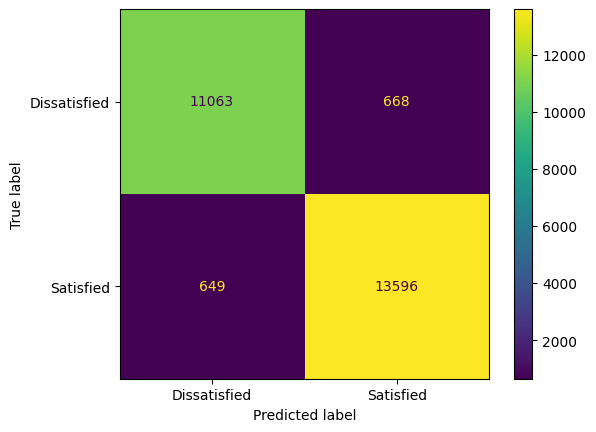

In [149]:
plot = ConfusionMatrixDisplay(matrix, display_labels=['Dissatisfied','Satisfied'] )
plot.plot()

In [150]:
report = classification_report(test_prediction, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     11712
           1       0.95      0.95      0.95     14264

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976



In [153]:
y_pred_proba = clsf.predict_proba(X_test)[:,1]
y_pred_proba

array([3.3582199e-02, 9.9863178e-01, 7.8832215e-01, ..., 3.1851779e-04,
       9.9990118e-01, 9.9371099e-01], dtype=float32)

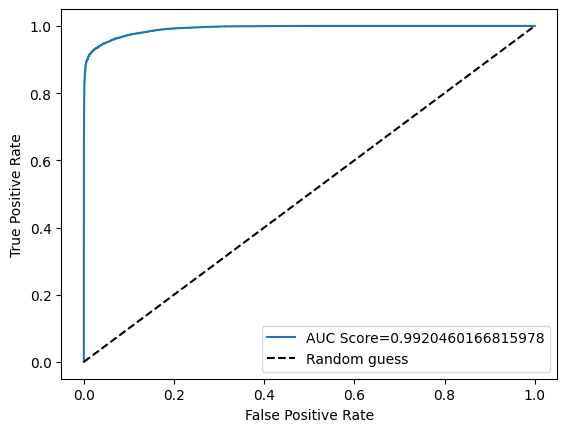

In [154]:
fpr, tpr, threshold = metrics.roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="AUC Score="+str(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()